<a href="https://colab.research.google.com/github/shhuangmust/AI/blob/112-2/Auto_Template_with_Peft_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter-Efficient Fine-Tuning (PEFT)
- 通過訓練一小組參數，使微調門檻降低，並且讓模型能夠適應和執行新的任務
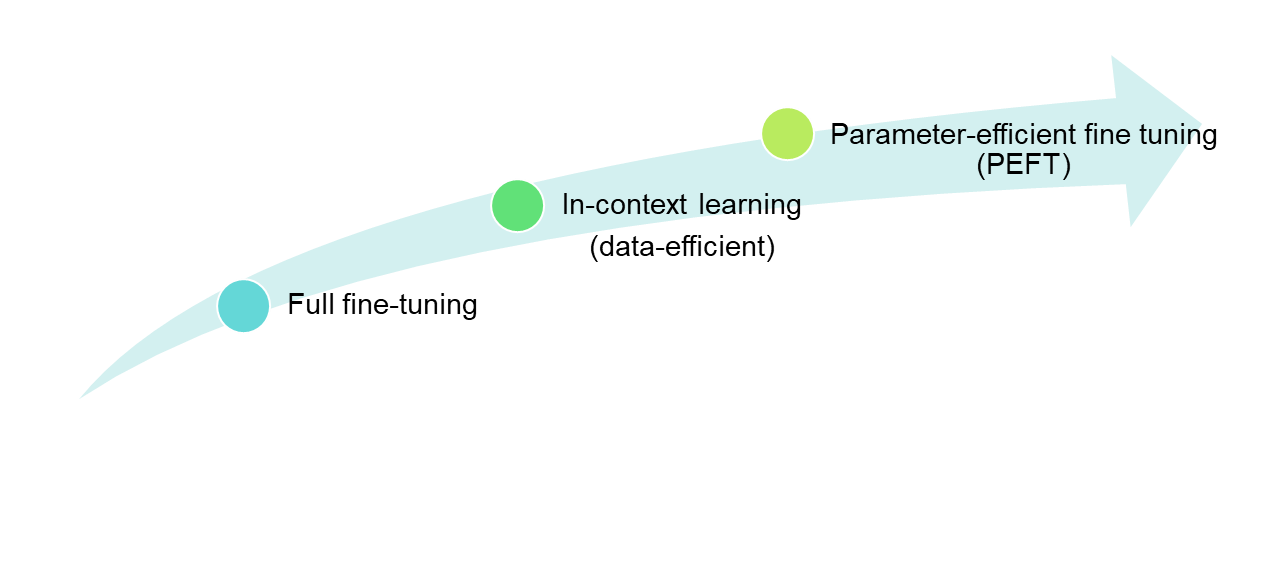

# 載入用Peft訓練出來的Adapter
https://huggingface.co/docs/transformers/main/en/peft

In [1]:
!pip install datasets bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 27.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.

In [2]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 28.3 MB/s eta 0:00:00


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import AutoPeftModelForCausalLM
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
peft_model_id = "huchiahsi/viggo-peft-model"

model = AutoPeftModelForCausalLM.from_pretrained(peft_model_id, device_map="auto", quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")


adapter_config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

adapter_model.bin:   0%|          | 0.00/85.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [4]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
這個賽車遊戲叫大賽車，可以多人玩，好玩，我可以Linux上和蘋果電腦上玩。

### Meaning representation:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

In [5]:
model.eval()
with torch.no_grad():
    print(tokenizer.decode(model.generate(**model_input, max_new_tokens=100, pad_token_id=2)[0], skip_special_tokens=True))


Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
這個賽車遊戲叫大賽車，可以多人玩，好玩，我可以Linux上和蘋果電腦上玩。

### Meaning representation:
inform(name[大賽車], rating[good], has_multiplayer[yes], has_linux_release[yes], has_mac_release[yes])

### Target sentence:
你知道那個2014年發行的遊戲The Forest of Doom嗎？

### Meaning representation:
request(name[The Forest of Doom], release_year[2014])
